# Tumoroscope in PyMC

## Setup

In [1]:
from dataclasses import dataclass

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

## Introduction

![tumoroscope overview](tumoroscope-overview.png)

## Model

In [2]:
@dataclass
class TumoroscopeData:
    """Tumoroscope model data."""

    K: int  # number of clones
    S: int  # number of spots
    P: int  # number of mutation positions
    F: np.ndarray  # Prevelance of clones from bulk-DNA seq.
    Lambda: np.ndarray  # Number of cell counted per spot
    C: np.ndarray  # Zygosity per position and clone
    zeta_s: float = 1  # Pi hyper-parameter
    F_0: float = 0.01  # "pseudo-frequency" for lower bound on clone proportion
    l: float = 100  # Scaling factor to discretize F
    r: float = 0.09  # shape parameter for Gamma over Phi
    p: float = 1  # rate parameter for Gamma over Phi


def _prefixed_index(n: int, prefix: str) -> list[str]:
    return [f"{prefix}{i}" for i in np.arange(n)]


def _check_tumoroscope_data(data: TumoroscopeData) -> None:
    assert data.F.sum() == 1.0
    assert data.F.ndim == 1
    assert data.F.shape[0] == data.K


def _make_tumoroscope_model_coords(data: TumoroscopeData) -> dict[str, list[str]]:
    coords = {
        "clone": _prefixed_index(data.K, "c"),
        "spot": _prefixed_index(data.S, "s"),
        "position": _prefixed_index(data.P, "p"),
    }
    return coords


def tumoroscope(data: TumoroscopeData) -> pm.Model:
    _check_tumoroscope_data(data)
    coords = _make_tumoroscope_model_coords(data)
    with pm.Model(coords=coords) as model:
        ζ_s = pm.ConstantData("ζ_s", data.zeta_s)
        ℓ = pm.ConstantData("ℓ", data.l)
        F_0 = pm.ConstantData("F0", data.F_0)
        F = pm.ConstantData("F", data.F)
        Λ = pm.ConstantData("Λ", data.Lambda, dims="spot")
        r = pm.ConstantData("r", data.r)
        p = pm.ConstantData("p", data.p)
        C = pm.ConstantData("C", data.C, dims=("position", "clone"))

        F_prime = pm.Deterministic("F_prime", ℓ * 20 * F / 20)

        Π = pm.Beta("Π", alpha=ζ_s / data.K, beta=1, dims=("spot", "clone"))
        Z = pm.Bernoulli("Z", p=Π, dims=("spot", "clone"))
        G = pm.Gamma("G", F_prime**Z * F_0 ** (1 - Z), 1, dims=("spot", "clone"))
        H = pm.Deterministic("H", G / G.sum(axis=1)[:, None], dims=("spot", "clone"))

        N = pm.Poisson("N", Λ, dims="spot")
        Φ = pm.Gamma("Φ", r, p, dims=("position", "clone"))
        D = pm.Poisson("D", N * H.dot(Φ.T).T, dims=("position", "spot"))

        _A_num = H[:, 1:].dot((Φ[:, 1:] * C[:, 1:]).T).T
        _A_denom = H[:, 1:].dot(Φ[:, 1:].T).T
        A = pm.Binomial("A", D, _A_num / _A_denom, dims=("position", "spot"))
    return model

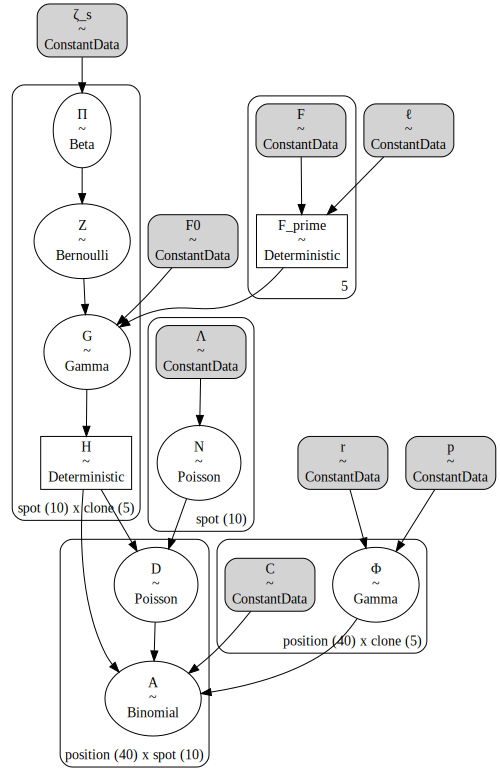

In [3]:
np.random.seed(234)
mock_tumor_data = TumoroscopeData(
    K=5,
    S=10,
    P=40,
    F=np.ones(5) / 5.0,
    Lambda=np.random.randint(1, 20, size=10),
    C=np.random.beta(2, 2, size=(40, 5)),
)

m = tumoroscope(mock_tumor_data)
pm.model_to_graphviz(m)

In [4]:
with m:
    prior_pred = pm.sample_prior_predictive(random_seed=123)

Sampling: [A, D, G, N, Z, Π, Φ]


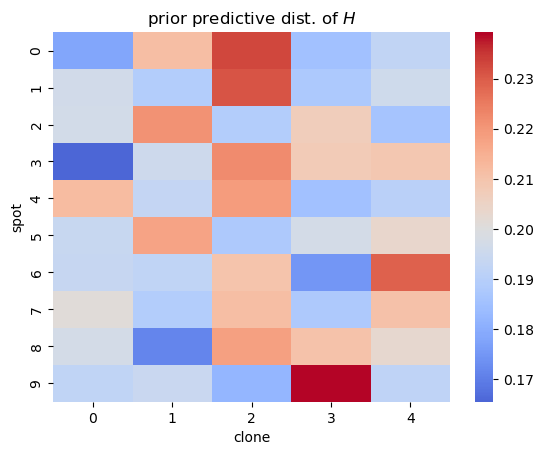

In [5]:
H_mean = prior_pred.prior["H"].values.squeeze().mean(axis=0)
ax = sns.heatmap(data=H_mean, cmap="coolwarm", center=1 / mock_tumor_data.K)
ax.set_xlabel("clone")
ax.set_ylabel("spot")
ax.set_title("prior predictive dist. of $H$")
plt.show()

TODO:

- generate mock data and test model
- explore prior distributions over the current user-supplied hyper-parameters
- try to use Dirichlet for $P(H|F^\prime,F_0,Z)$ like the Methods explains

---

## Session information

In [6]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-05

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: jhcookmac.harvardsecure.wireless.med.harvard.edu

Git branch: tumoroscope

matplotlib: 3.6.0
pandas    : 1.5.0
seaborn   : 0.12.0
janitor   : 0.22.0
numpy     : 1.23.3
pymc      : 4.2.1
arviz     : 0.12.1

